In [37]:
# importing required libraries
import numpy as np
import pandas as pd

import datetime as dt
import yfinance as yf
import pandas_datareader.data as web
import cpi
import wbdata

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from scipy.optimize import minimize

In [2]:
# customize seed for different stocks
np.random.seed(42)

# list of all potential stocks (can be customized)
ticker_list = ['AAPL','AXP', 'BAC', 'C', 'CSCO', 'GS', 'IBM', 'INTC', 'JPM', 'MSFT', 'NVDA', 'CRM', 'QCOM', 'NOW', 'ORCL', 'AVGO', 'TXN', 'GDDY',
               'WIX', 'TSM', 'TSLA', 'SNOW', 'HUBS', 'DOCU', 'MS']

# selecting 15 random stocks
stock_list = np.random.choice(ticker_list,15,replace=False)
print(f'These are the fifteen stocks assigned to you: {" ".join(stock_list)}')

# sorting the list from A-Z
stock_list = list(np.sort(stock_list))

These are the fifteen stocks assigned to you: JPM TXN AAPL DOCU CRM MSFT NOW AXP HUBS GS BAC QCOM AVGO C CSCO


In [3]:
# finding optimal historical portfolio since 2000 to today, using 15 stocks. 
# Assume no short-selling constraints

# defining start and end date
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2024, 12, 31)

# getting returns of the stocks
# calculates returns using adjusted close price
# ensures that we have returns of only those dates where all companies have available information
returns = yf.download(stock_list, start-pd.offsets.BDay(1), end+pd.offsets.BDay(1), auto_adjust=False)['Adj Close'].pct_change().dropna()

# gets all returns Close, high, low, open, volume
#returns = yf.download(stock_list, start, end)

# getting S&P 500 data
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(period="25y")
sp500_data['SP500'] = sp500_data['Close'].pct_change()
sp500_data = sp500_data.drop(columns=["Open", "High", "Low", "Close", "Volume", "Dividends", "Stock Splits"])

# reformatting date
sp500_data.index = sp500_data.index.strftime('%m-%d-%Y')
sp500_data.index = pd.to_datetime(sp500_data.index)

# sp500_mon = sp500_data.resample(rule = 'ME').apply(lambda x: x.add(1).prod().sub(1))



[*********************100%***********************]  15 of 15 completed


In [4]:
# adding sp500 data to the returns dataset
returns = pd.merge(returns, sp500_data, left_index = True, right_index = True )

# getting monthly returns
returns_mon = returns.resample(rule = 'ME').apply(lambda x: x.add(1).prod().sub(1))
returns_mon

,AAPL,AVGO,AXP,BAC,C,CRM,CSCO,DOCU,GS,HUBS,JPM,MSFT,NOW,QCOM,TXN,SP500
Date,,,,,,,,,,,,,,,,
2018-04-30,0.018113,-0.014434,-0.008634,-0.007629,-0.010436,0.006405,-0.009394,-0.027687,-0.006130,-0.018081,-0.005668,-0.024003,0.018140,-0.001957,-0.010536,-0.008187
2018-05-31,0.135124,0.098727,-0.004557,-0.025446,-0.018520,0.068931,-0.035674,0.289412,-0.048887,0.144476,-0.016271,0.061467,0.069038,0.151289,0.109965,0.021608
2018-06-30,-0.009418,-0.024502,-0.003052,-0.029270,0.003449,0.054666,0.007492,0.063040,-0.023508,0.034654,-0.026259,-0.002327,-0.028940,-0.034412,-0.014833,0.004842
2018-07-31,0.027983,-0.086012,0.019156,0.095424,0.074268,0.005499,-0.009538,0.017941,0.076439,-0.010367,0.109162,0.075753,0.020235,0.142018,0.015295,0.036022
2018-08-31,0.200422,-0.012355,0.064912,0.001619,-0.002796,0.113234,0.129582,0.158442,0.004917,0.157937,-0.003219,0.062993,0.115935,0.072086,0.009702,0.030263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.032353,0.013318,0.022170,0.010915,-0.025235,-0.022798,0.043137,0.067231,0.008327,0.004104,0.056391,-0.001095,0.049866,-0.031224,0.051666,0.022835
2024-09-30,0.017467,0.062937,0.048521,-0.019909,-0.000639,0.083985,0.053027,0.048640,-0.029672,0.065181,-0.062011,0.031548,0.046070,-0.024936,-0.036251,0.020197
2024-10-31,-0.030429,-0.015826,-0.001528,0.053931,0.025080,0.064521,0.036989,0.117410,0.045808,0.043623,0.058901,-0.055659,0.043158,-0.042811,-0.010033,-0.009897


In [5]:
# pd.reset_option('display.max_rows',None)

# # pd.set_option('display.max_rows', None)  # Show all rows


In [6]:
# getting std deviation for Jan 2019 for SP500
print(returns.loc[(returns.index.year == 2019) & (returns.index.month == 1)]['SP500'].std())

# getting monthly std dev
monthly_std = returns.groupby(by=[returns.index.month, returns.index.year]).std()

# placing index correctly
monthly_std.index = pd.to_datetime(monthly_std.index.map(lambda x: f"{x[1]}-{x[0]}"), format="%Y-%m")
monthly_std.sort_index(inplace=True)

# matching index to monthly returns index
monthly_std.index = returns_mon.index

0.011677586389697103


In [7]:
# joining monthly returns and monthly std dev data
result = pd.concat([returns_mon, monthly_std], axis=1, keys=['Returns', 'StdDev'])

# defining column names
result.columns = result.columns.get_level_values(1) + '_' + result.columns.get_level_values(0).astype(str)

# showing data
result

,AAPL_Returns,AVGO_Returns,AXP_Returns,BAC_Returns,C_Returns,CRM_Returns,CSCO_Returns,DOCU_Returns,GS_Returns,HUBS_Returns,...,CSCO_StdDev,DOCU_StdDev,GS_StdDev,HUBS_StdDev,JPM_StdDev,MSFT_StdDev,NOW_StdDev,QCOM_StdDev,TXN_StdDev,SP500_StdDev
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-30,0.018113,-0.014434,-0.008634,-0.007629,-0.010436,0.006405,-0.009394,-0.027687,-0.006130,-0.018081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-31,0.135124,0.098727,-0.004557,-0.025446,-0.018520,0.068931,-0.035674,0.289412,-0.048887,0.144476,...,0.012305,0.026296,0.010957,0.015443,0.014172,0.008415,0.013723,0.015838,0.010325,0.006550
2018-06-30,-0.009418,-0.024502,-0.003052,-0.029270,0.003449,0.054666,0.007492,0.063040,-0.023508,0.034654,...,0.010629,0.038368,0.009118,0.029476,0.010105,0.010327,0.018725,0.010730,0.012988,0.005575
2018-07-31,0.027983,-0.086012,0.019156,0.095424,0.074268,0.005499,-0.009538,0.017941,0.076439,-0.010367,...,0.013935,0.032875,0.009614,0.018243,0.013648,0.013346,0.022173,0.020328,0.012673,0.005448
2018-08-31,0.200422,-0.012355,0.064912,0.001619,-0.002796,0.113234,0.129582,0.158442,0.004917,0.157937,...,0.008982,0.031341,0.011369,0.021076,0.007395,0.007513,0.015087,0.009310,0.013441,0.004431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.032353,0.013318,0.022170,0.010915,-0.025235,-0.022798,0.043137,0.067231,0.008327,0.004104,...,0.020368,0.020370,0.018847,0.018766,0.014808,0.012256,0.015843,0.031815,0.025276,0.012262
2024-09-30,0.017467,0.062937,0.048521,-0.019909,-0.000639,0.083985,0.053027,0.048640,-0.029672,0.065181,...,0.009361,0.022923,0.019290,0.015217,0.015982,0.011563,0.017725,0.024127,0.021164,0.008719
2024-10-31,-0.030429,-0.015826,-0.001528,0.053931,0.025080,0.064521,0.036989,0.117410,0.045808,0.043623,...,0.011385,0.019964,0.012744,0.018603,0.014478,0.015659,0.017850,0.022151,0.018249,0.006936


In [8]:
# getting risk free rate
rf = web.DataReader('F-F_Research_Data_Factors','famafrench', start, end)[0][['RF']].div(100)

# normalizing the index to end-of-month timestamps
rf.index = rf.index.to_timestamp(how='end').normalize()

# showing rf data
rf

C:\Users\rishi\AppData\Local\Temp\ipykernel_76944\712724032.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  rf = web.DataReader('F-F_Research_Data_Factors','famafrench', start, end)[0][['RF']].div(100)
C:\Users\rishi\AppData\Local\Temp\ipykernel_76944\712724032.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  rf = web.DataReader('F-F_Research_Data_Factors','famafrench', start, end)[0][['RF']].div(100)


,RF
Date,
2000-01-31,0.0041
2000-02-29,0.0043
2000-03-31,0.0047
2000-04-30,0.0046
2000-05-31,0.0050
...,...
2024-08-31,0.0048
2024-09-30,0.0040
2024-10-31,0.0039


In [9]:
# adding rf data to the monthly returns and std dev data
result = pd.merge(result, rf, how='left', left_index=True, right_index=True)
result

,AAPL_Returns,AVGO_Returns,AXP_Returns,BAC_Returns,C_Returns,CRM_Returns,CSCO_Returns,DOCU_Returns,GS_Returns,HUBS_Returns,...,DOCU_StdDev,GS_StdDev,HUBS_StdDev,JPM_StdDev,MSFT_StdDev,NOW_StdDev,QCOM_StdDev,TXN_StdDev,SP500_StdDev,RF
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-30,0.018113,-0.014434,-0.008634,-0.007629,-0.010436,0.006405,-0.009394,-0.027687,-0.006130,-0.018081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0014
2018-05-31,0.135124,0.098727,-0.004557,-0.025446,-0.018520,0.068931,-0.035674,0.289412,-0.048887,0.144476,...,0.026296,0.010957,0.015443,0.014172,0.008415,0.013723,0.015838,0.010325,0.006550,0.0014
2018-06-30,-0.009418,-0.024502,-0.003052,-0.029270,0.003449,0.054666,0.007492,0.063040,-0.023508,0.034654,...,0.038368,0.009118,0.029476,0.010105,0.010327,0.018725,0.010730,0.012988,0.005575,0.0014
2018-07-31,0.027983,-0.086012,0.019156,0.095424,0.074268,0.005499,-0.009538,0.017941,0.076439,-0.010367,...,0.032875,0.009614,0.018243,0.013648,0.013346,0.022173,0.020328,0.012673,0.005448,0.0016
2018-08-31,0.200422,-0.012355,0.064912,0.001619,-0.002796,0.113234,0.129582,0.158442,0.004917,0.157937,...,0.031341,0.011369,0.021076,0.007395,0.007513,0.015087,0.009310,0.013441,0.004431,0.0016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.032353,0.013318,0.022170,0.010915,-0.025235,-0.022798,0.043137,0.067231,0.008327,0.004104,...,0.020370,0.018847,0.018766,0.014808,0.012256,0.015843,0.031815,0.025276,0.012262,0.0048
2024-09-30,0.017467,0.062937,0.048521,-0.019909,-0.000639,0.083985,0.053027,0.048640,-0.029672,0.065181,...,0.022923,0.019290,0.015217,0.015982,0.011563,0.017725,0.024127,0.021164,0.008719,0.0040
2024-10-31,-0.030429,-0.015826,-0.001528,0.053931,0.025080,0.064521,0.036989,0.117410,0.045808,0.043623,...,0.019964,0.012744,0.018603,0.014478,0.015659,0.017850,0.022151,0.018249,0.006936,0.0039


In [10]:
# getting CPI data from FRED
cpi = web.DataReader('CPIAUCSL', 'fred', start, end)

# calculating monthly inflation rates as percentage change
inflation_rate = cpi.pct_change().dropna()

# normalizing the index to end-of-month timestamps
inflation_rate.index = inflation_rate.index.to_period('M').to_timestamp(how='end').normalize()

# naming column
inflation_rate.columns = ['Inflation Rate']

# showing data
inflation_rate

,Inflation Rate
DATE,
2000-02-29,0.004135
2000-03-31,0.005882
2000-04-30,-0.000585
2000-05-31,0.001755
2000-06-30,0.005841
...,...
2024-08-31,0.001802
2024-09-30,0.002292
2024-10-31,0.002265


In [11]:
# adding inflation rate data to the monthly returns and std dev data
result = pd.merge(result, inflation_rate, how = 'left', left_index=True, right_index=True) 

In [12]:
# pd.set_option('display.max_rows', None)
#pd.reset_option('display.max_rows') # not sure wht this does?

In [13]:
rolling_avg = returns.rolling(window=30).mean()
rolling_avg

,AAPL,AVGO,AXP,BAC,C,CRM,CSCO,DOCU,GS,HUBS,JPM,MSFT,NOW,QCOM,TXN,SP500
Date,,,,,,,,,,,,,,,,
2018-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.004749,0.011294,0.001273,-0.001009,0.000635,0.000630,0.000727,0.006606,-0.000845,0.002161,0.000479,0.001798,0.002351,-0.001431,-0.003712,0.000244
2024-12-26,0.004855,0.012585,0.001838,-0.000723,0.001171,0.000424,0.000754,0.006416,-0.000395,0.001308,0.000556,0.001305,0.001761,-0.000638,-0.003358,0.000327
2024-12-27,0.004281,0.012594,0.001616,-0.000887,0.001071,0.000050,0.000282,0.005719,-0.000776,0.000604,0.000063,0.000557,0.001313,-0.000299,-0.002347,-0.000049


In [14]:
# Resample to monthly, grabbing the last daily value of each month
rolling_monthly = rolling_avg.resample('M').last()
rolling_monthly = rolling_monthly.add_suffix("_30dRollAvg")
rolling_monthly

C:\Users\rishi\AppData\Local\Temp\ipykernel_76944\3754405581.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rolling_monthly = rolling_avg.resample('M').last()


,AAPL_30dRollAvg,AVGO_30dRollAvg,AXP_30dRollAvg,BAC_30dRollAvg,C_30dRollAvg,CRM_30dRollAvg,CSCO_30dRollAvg,DOCU_30dRollAvg,GS_30dRollAvg,HUBS_30dRollAvg,JPM_30dRollAvg,MSFT_30dRollAvg,NOW_30dRollAvg,QCOM_30dRollAvg,TXN_30dRollAvg,SP500_30dRollAvg
Date,,,,,,,,,,,,,,,,
2018-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-30,-0.000309,0.000970,-0.001026,-0.002736,-0.002145,0.002701,-0.000289,0.006141,-0.002514,0.004583,-0.002604,0.000874,0.000286,-0.000081,0.000035,-0.000004
2018-07-31,0.000317,-0.004941,0.000539,0.001737,0.002560,-0.000522,-0.001139,-0.005023,0.000911,-0.003804,0.002290,0.001763,-0.001706,0.002819,-0.000642,0.000524
2018-08-31,0.005991,0.001464,0.001929,0.000916,0.001229,0.001393,0.004341,0.006517,0.001031,0.002738,0.001008,0.002034,0.001099,0.005438,-0.000507,0.001177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.000822,0.001961,0.002353,-0.001597,-0.000777,0.000858,0.002349,0.002120,0.002044,0.001506,0.002401,-0.001402,0.004744,-0.001329,0.002960,0.000928
2024-09-30,0.001087,0.002017,0.002600,0.000579,0.000780,0.001503,0.002484,0.003163,-0.000277,0.002284,-0.000395,0.000986,0.002729,0.000024,0.001187,0.001259
2024-10-31,-0.000358,0.000686,0.000335,0.000852,0.000781,0.003128,0.002396,0.006218,0.000980,0.001649,0.002047,-0.002453,0.000647,-0.001991,-0.000362,-0.000029


In [15]:
result = pd.merge(result, rolling_monthly, left_index=True, right_index=True)

In [16]:
result

,AAPL_Returns,AVGO_Returns,AXP_Returns,BAC_Returns,C_Returns,CRM_Returns,CSCO_Returns,DOCU_Returns,GS_Returns,HUBS_Returns,...,CSCO_30dRollAvg,DOCU_30dRollAvg,GS_30dRollAvg,HUBS_30dRollAvg,JPM_30dRollAvg,MSFT_30dRollAvg,NOW_30dRollAvg,QCOM_30dRollAvg,TXN_30dRollAvg,SP500_30dRollAvg
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-30,0.018113,-0.014434,-0.008634,-0.007629,-0.010436,0.006405,-0.009394,-0.027687,-0.006130,-0.018081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-31,0.135124,0.098727,-0.004557,-0.025446,-0.018520,0.068931,-0.035674,0.289412,-0.048887,0.144476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-30,-0.009418,-0.024502,-0.003052,-0.029270,0.003449,0.054666,0.007492,0.063040,-0.023508,0.034654,...,-0.000289,0.006141,-0.002514,0.004583,-0.002604,0.000874,0.000286,-0.000081,0.000035,-0.000004
2018-07-31,0.027983,-0.086012,0.019156,0.095424,0.074268,0.005499,-0.009538,0.017941,0.076439,-0.010367,...,-0.001139,-0.005023,0.000911,-0.003804,0.002290,0.001763,-0.001706,0.002819,-0.000642,0.000524
2018-08-31,0.200422,-0.012355,0.064912,0.001619,-0.002796,0.113234,0.129582,0.158442,0.004917,0.157937,...,0.004341,0.006517,0.001031,0.002738,0.001008,0.002034,0.001099,0.005438,-0.000507,0.001177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.032353,0.013318,0.022170,0.010915,-0.025235,-0.022798,0.043137,0.067231,0.008327,0.004104,...,0.002349,0.002120,0.002044,0.001506,0.002401,-0.001402,0.004744,-0.001329,0.002960,0.000928
2024-09-30,0.017467,0.062937,0.048521,-0.019909,-0.000639,0.083985,0.053027,0.048640,-0.029672,0.065181,...,0.002484,0.003163,-0.000277,0.002284,-0.000395,0.000986,0.002729,0.000024,0.001187,0.001259
2024-10-31,-0.030429,-0.015826,-0.001528,0.053931,0.025080,0.064521,0.036989,0.117410,0.045808,0.043623,...,0.002396,0.006218,0.000980,0.001649,0.002047,-0.002453,0.000647,-0.001991,-0.000362,-0.000029


# MLP

In [17]:
# dropping null values
result.dropna(inplace=True)

In [18]:
# getting dynamic columns
returns_col = [col for col in result.columns if '_Return' in col]
stddev_col = [col for col in result.columns if '_StdDev' in col]
rollavg30d_col = [col for col in result.columns if '_30dRollAvg' in col]

In [19]:
# getting names of mlp input features
mlp_inputs = stddev_col + ['RF', 'Inflation Rate'] + rollavg30d_col

# getting X
X = result[mlp_inputs].values

# getting y
y = result[returns_col].values

In [20]:
# splitting data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# scaling training and testing data using MinMaxScaler separately
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train).round(4)
scaled_X_test = scaler.transform(X_test).round(4)

In [22]:
# adding a bias column to scaled data
scaled_X_train = np.hstack((np.ones((scaled_X_train.shape[0], 1)), scaled_X_train))
scaled_X_test = np.hstack((np.ones((scaled_X_test.shape[0], 1)), scaled_X_test))

In [23]:
# initializing random weights
#np.random.seed(21)

# defining number of nodes
nodes = 8

# initializing W1
W1 = np.random.randn(scaled_X_train.shape[1], nodes)

# initializing W2
W2 = np.random.randn(nodes, y_train.shape[1])

# printing initial weights
print("W1:", W1)
print("W2:", W2)

W1: [[ 0.24196227 -1.91328024 -1.72491783 -0.56228753 -1.01283112  0.31424733
  -0.90802408 -1.4123037 ]
 [ 1.46564877 -0.2257763   0.0675282  -1.42474819 -0.54438272  0.11092259
  -1.15099358  0.37569802]
 [-0.60063869 -0.29169375 -0.60170661  1.85227818 -0.01349722 -1.05771093
   0.82254491 -1.22084365]
 [ 0.2088636  -1.95967012 -1.32818605  0.19686124  0.73846658  0.17136828
  -0.11564828 -0.3011037 ]
 [-1.47852199 -0.71984421 -0.46063877  1.05712223  0.34361829 -1.76304016
   0.32408397 -0.38508228]
 [-0.676922    0.61167629  1.03099952  0.93128012 -0.83921752 -0.30921238
   0.33126343  0.97554513]
 [-0.47917424 -0.18565898 -1.10633497 -1.19620662  0.81252582  1.35624003
  -0.07201012  1.0035329 ]
 [ 0.36163603 -0.64511975  0.36139561  1.53803657 -0.03582604  1.56464366
  -2.6197451   0.8219025 ]
 [ 0.08704707 -0.29900735  0.09176078 -1.98756891 -0.21967189  0.35711257
   1.47789404 -0.51827022]
 [-0.8084936  -0.50175704  0.91540212  0.32875111 -0.5297602   0.51326743
   0.09707755

In [24]:
# uses the ReLU activation function for h and the sigmoid activation function for the output
def f(x):
    h = np.maximum(0, W1.T.dot(x))
    return 1 / (1 + np.exp(-np.dot(W2.T, h)))

In [31]:
# gradient descent

# defining learning rate
eta = 0.01

# keeping track of gradient descent error and monitoring convergence
errors = []
epochs = 500

# getting the number of rows
n = scaled_X_train.shape[0]

for epoch in range(epochs):

    # initializing dW2 to have same dimensions as W2
    dW2 = np.zeros_like(W2)

    # updating W2
    for i in range(n):
        # reshaping data format
        x = scaled_X_train[i].reshape(-1, 1)

        # finding h using reLU activation
        h = np.maximum(0, W1.T.dot(x))

        er = f(x) - y_train[i].reshape(-1,1)
        
        # adding W2 gradients
        dW2 += (2/n) * h.dot(er.T)

    # applying gradient descent to update W2
    W2 = W2 - eta * dW2

    # initializing dW1 to have same dimensions as W1
    dW1 = np.zeros_like(W1)

    # updating W1
    for i in range(n):
        # reshaping data format
        x = scaled_X_train[i].reshape(-1, 1)
        
        # finding h using reLU activation
        h = np.maximum(0, W1.T.dot(x))

        # calculating gradient of reLU
        mat1 = np.heaviside(h, 0)

        er = f(x) - y_train[i].reshape(-1,1)
        delta = W2.dot(er) * mat1

        # adding W1 gradients
        dW1 += (2/n) * x.dot(delta.T)

    # applying gradient descent to update W1
    W1 = W1 - eta * dW1

    # calculating errors
    y_pred = 1 / (1 + np.exp(-np.dot(W2.T, np.maximum(0, np.dot(W1.T, scaled_X_train.T)))))

    # using loss function (MSE)
    e = (1/n) * np.sum((y_pred.T - y_train) ** 2)

    # adding errors to the list
    errors.append(e)

# print("Final W1:", W1)
# print("Final W2:", W2)
print("Final Loss:", e)

Final Loss: 0.15708036475956652


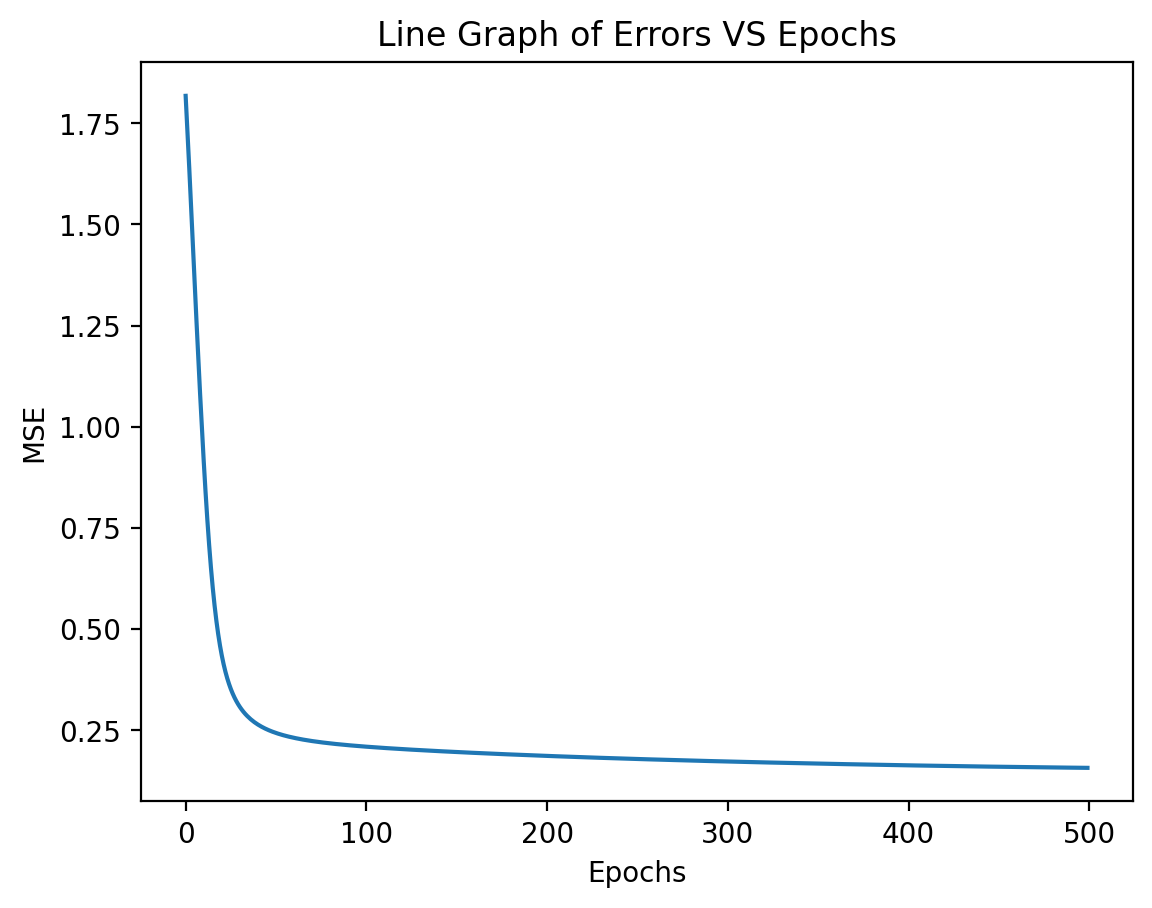

In [32]:
# making a graph with title and axes labels
plt.plot(range(epochs), errors, label='line')
plt.title("Line Graph of Errors VS Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

In [38]:
# predicting on the scaled test dataset
h = np.maximum(0, np.dot(W1.T, scaled_X_test.T))
y_test_pred = 1 / (1 + np.exp(-np.dot(W2.T, h))).T

# Calculate overall MSE, MAE, and R² score
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test R² Score:", r2)


# checking if y_test_pred are greater than 0.5 where True = 1, False = 0
# y_check = (y_test_pred > 0.5).astype(int)

# accuracy = np.round(np.mean(y_check == y_test) * 100, 5)
# print("Test Accuracy:", accuracy, "%")

Test MSE: 0.006671174670049055
Test MAE: 0.06287410041330649
Test R² Score: -0.1679620394810694
